# FINANCIAL INCLUSION EDA + MODELLING
### Can you predict who in Africa is most likely to have a bank account?


In [1]:
# !pip install catboost

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

## Import necessary Libraries and load the data
Libraries help reduce coding errors, make programmers more efficient, and make software smaller in size (and lines of code). Instead of writing long lines of code to accomplish a common task, coders can simply call upon a library – often with a single line of code – to perform that task instead.

In [3]:
import pandas as pd #A fast, powerful, flexible and easy to use open source data analysis and manipulation tool
import numpy as np # Library for working with arrays

# creating visualizations in python
import matplotlib.pyplot as plt 
import plotly.express as px
from pylab import rcParams
import seaborn as sb
sb.set_style('darkgrid')
rcParams['figure.figsize'] = 8,8
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline


import catboost as catt # does not need parameter tuning but slow
import xgboost as xgb # very poor with no proper tuning but very good when tuned
import lightgbm as lgb # very fastt but also needs to be tuned, prone to overfitting

from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import StratifiedKFold,StratifiedGroupKFold,RepeatedStratifiedKFold,train_test_split

pd.options.display.max_rows = 2200
import gc 

In [4]:
# path = "/content/drive/MyDrive/Tourism_wINNER/"
path = "./"

In [5]:
#import data
train = pd.read_csv(path+'Train.csv')
test=  pd.read_csv(path+'Test.csv')

ftest = test.copy()
submission = pd.read_csv(path+'SampleSubmission.csv')


In [6]:
# How to check the number of rows and columns in a dataset
train.shape,test.shape

((23524, 13), (10086, 12))

In [7]:
# How to see the first 5 rows in a dataset
train.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


### Lets view some columns and see if we can come up with some hypothesis through general knowledge

In [8]:
train.columns

Index(['country', 'year', 'uniqueid', 'bank_account', 'location_type',
       'cellphone_access', 'household_size', 'age_of_respondent',
       'gender_of_respondent', 'relationship_with_head', 'marital_status',
       'education_level', 'job_type'],
      dtype='object')

## Questions we can ask 
#### How does country affect bank adaptation? Are there countries which lead in bank adaptation?
#### Is there any relationship between bank adaptation and year? How is the relationship?
#### How does banking adaptation relate in urban location to rural location?
#### How does cellphone access affect banking adaptation?
#### What is the relationship between household size and owning a bank account?
#### How does age affect bank adaptation?
#### Does gender affect bank adaptation?
#### Whats relationship with head got to do with owning a bank account?
#### Does the marital status of a person have a relationship with owning a bank account?
#### Whats the relationship between the education level of a person and bank adaptation?
#### Does job type affect bank adaptation?

## Try to answer the above questions with Hypothesis based on general Knowledge
#### More developed countries will have more people with bank accounts than poor developed countries. You can also compare this between political stable countries and political instable countries
#### As years pass by, bank adaptation rate keeps increasing as more people get educated and more social awareness by the banks
#### People in urban centers will likely have a high bank adaptation rate than people in the rural centers because of more opportunities
#### Mobile banking will help increase the bank adaptation rate. So people with cellphones will likely own more bank accounts.
#### Large household sizes will likely own more bank accounts than small household sizes. Loans for paying fees e.t.c
#### People with ages between age 25  and beyond will most likely have bank accounts because most of them work
#### Gender - Gray area. You can't say for sure. But for developing countries like African countries Males tend to have better jobs than females
#### Relationship with head? Not sure of their relationship
#### A person with a family will most likely own a bank account compared to a single person
#### A more educated person is more likely to own a bank account
#### A person with a white collar job is more likely to own a bank account

## Now let us go to the data and see if these hypothesis stands

### DATATYPE DESCRIPTION AND  STATISTICAL INFORMATION

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 23524 non-null  object
 1   year                    23524 non-null  int64 
 2   uniqueid                23524 non-null  object
 3   bank_account            23524 non-null  object
 4   location_type           23524 non-null  object
 5   cellphone_access        23524 non-null  object
 6   household_size          23524 non-null  int64 
 7   age_of_respondent       23524 non-null  int64 
 8   gender_of_respondent    23524 non-null  object
 9   relationship_with_head  23524 non-null  object
 10  marital_status          23524 non-null  object
 11  education_level         23524 non-null  object
 12  job_type                23524 non-null  object
dtypes: int64(3), object(10)
memory usage: 2.3+ MB


#### We can see a mixture of object columns and int ones with object columns being the majority ones

In [10]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
year,23524.0,2016.975939,0.847371,2016.0,2016.0,2017.0,2018.0,2018.0
household_size,23524.0,3.797483,2.227613,1.0,2.0,3.0,5.0,21.0
age_of_respondent,23524.0,38.805220,16.520569,16.0,26.0,35.0,49.0,100.0


#### From this data we can actually see that there is no outliers. It is possible for someone to live upto 100 but we don't expect them to be the majority

## Missing values

In [11]:
train.isnull().sum()

country                   0
year                      0
uniqueid                  0
bank_account              0
location_type             0
cellphone_access          0
household_size            0
age_of_respondent         0
gender_of_respondent      0
relationship_with_head    0
marital_status            0
education_level           0
job_type                  0
dtype: int64

In [12]:
test.isnull().sum()

country                   0
year                      0
uniqueid                  0
location_type             0
cellphone_access          0
household_size            0
age_of_respondent         0
gender_of_respondent      0
relationship_with_head    0
marital_status            0
education_level           0
job_type                  0
dtype: int64

In [13]:
# #check for missing values
# percent_missing = train.isnull().sum() * 100 / len(train)
# missing_value_train = pd.DataFrame({'column_name': train.columns,
#                                  'percent_missing': percent_missing})
# missing_value_train

#### No columns with missing values. But if there were missing values we could have filled them with the mean or median for numerical columns and mode for cat features. Some libraries do not need filling of missing values e.g catboost, xgboost and lightgbm

#### More advanced ways of filling missing values:
* Using a high arbitrary value for numerical columns
* Using an Unknown new column for categorical columns
* Iterative Imputer
* knn imputer
* lgbm imputer

#### For timeseries data:
* ffill
* bfill


### Fill missing values 

### Checking the number of unique values in each column

In [14]:
# check unique values in dataset
train.apply(lambda x: len(x.unique()))

country                      4
year                         3
uniqueid                  8735
bank_account                 2
location_type                2
cellphone_access             2
household_size              20
age_of_respondent           85
gender_of_respondent         2
relationship_with_head       6
marital_status               5
education_level              6
job_type                    10
dtype: int64

In [15]:
## this code creates a list of all categorical columns and numerical columns

cat_columns = [col for col in train.select_dtypes('object').columns if col not in ['uniqueid']]

num_columns = [col for col in train.select_dtypes(['int', 'float']).columns]

## Categorical Data
* One thing, you should always make sure that similar categorical columns are both in train and test 
* If there are not the same then you have to find a new way to deal with that either in preprocessing or cross validation

* The best way to share your insights is using visualizations. For categorical columns we can use barcharts and piecharts 

### Target: Bank Account

In [16]:
train['bank_account'].value_counts()

No     20212
Yes     3312
Name: bank_account, dtype: int64

Text(0.5, 0, 'bank_account')

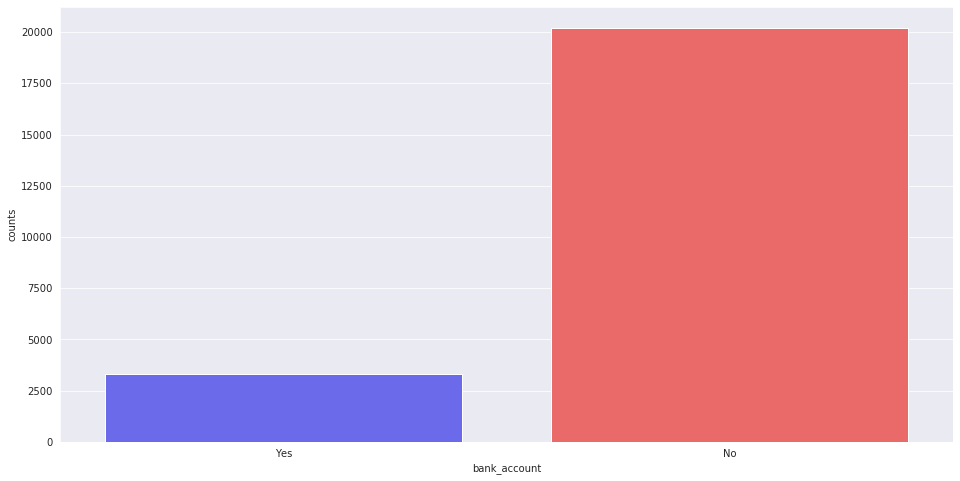

In [17]:
plt.figure(figsize=(16,8))
sb.countplot(train['bank_account'], palette='seismic')
plt.ylabel('counts')
plt.xlabel('bank_account')

### Country

In [18]:
train['country'].value_counts()

Rwanda      8735
Tanzania    6620
Kenya       6068
Uganda      2101
Name: country, dtype: int64

In [19]:
test['country'].value_counts()

Rwanda      3745
Tanzania    2839
Kenya       2601
Uganda       901
Name: country, dtype: int64

Text(0.5, 0, 'country')

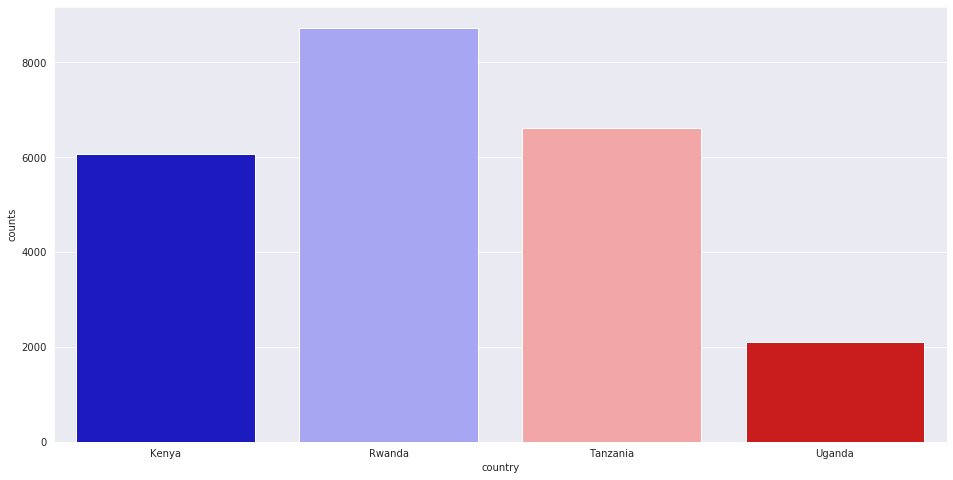

In [20]:
plt.figure(figsize=(16,8))
sb.countplot(train['country'], palette='seismic')
plt.ylabel('counts')
plt.xlabel('country')

### Question: How does country affect bank adaptation? Are there countries which lead in bank adaptation?

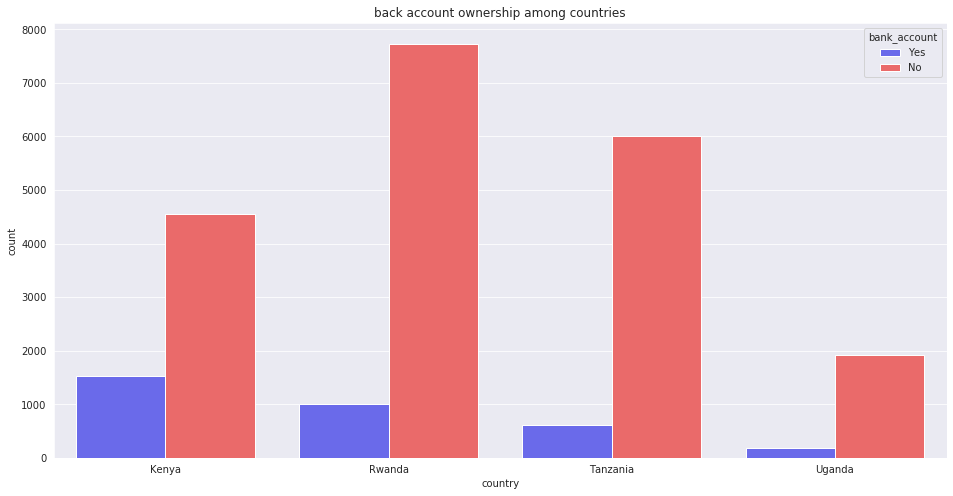

In [21]:
plt.figure(figsize=(16,8))
sb.countplot(train['country'], hue = train['bank_account'],palette="seismic")
plt.title("back account ownership among countries")
plt.show()

### Location type

In [22]:
train['location_type'].value_counts()

Rural    14343
Urban     9181
Name: location_type, dtype: int64

In [23]:
test['location_type'].value_counts()

Rural    6189
Urban    3897
Name: location_type, dtype: int64

Text(0.5, 0, 'location_type')

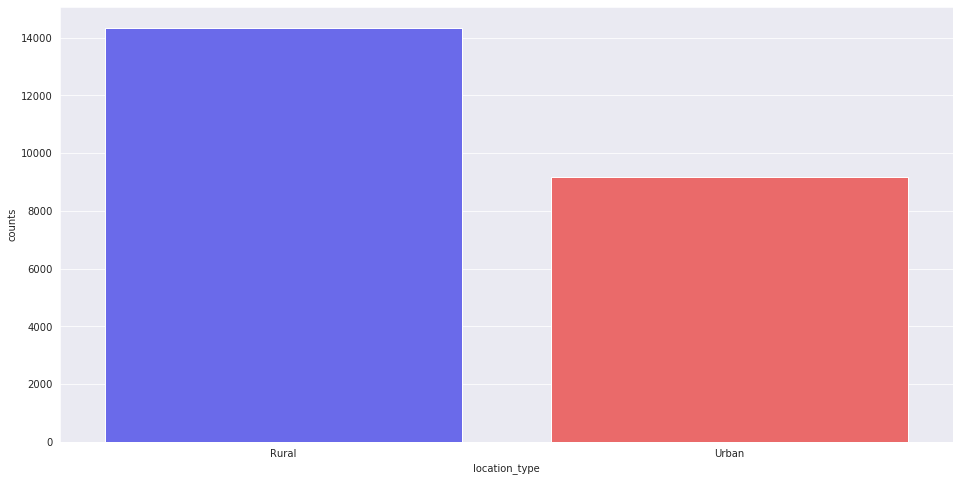

In [24]:
plt.figure(figsize=(16,8))
sb.countplot(train['location_type'], palette='seismic')
plt.ylabel('counts')
plt.xlabel('location_type')

 ### Question: How does banking adaptation relate in urban location to rural location?

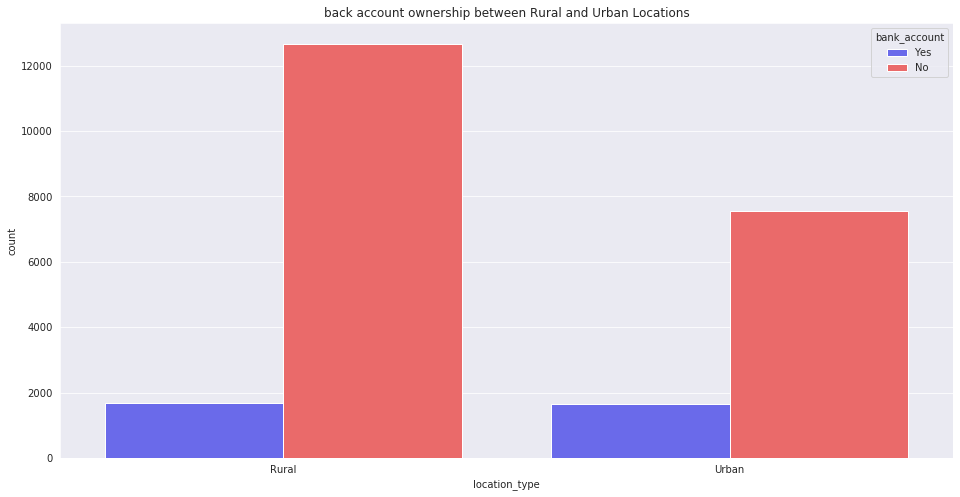

In [25]:
plt.figure(figsize=(16,8))
sb.countplot(train['location_type'], hue = train['bank_account'], palette='seismic')
plt.title("back account ownership between Rural and Urban Locations")
plt.show()

### cellphone_access

In [26]:
train['cellphone_access'].value_counts()

Yes    17454
No      6070
Name: cellphone_access, dtype: int64

In [27]:
test['cellphone_access'].value_counts()

Yes    7559
No     2527
Name: cellphone_access, dtype: int64

Text(0.5, 0, 'cellphone_access')

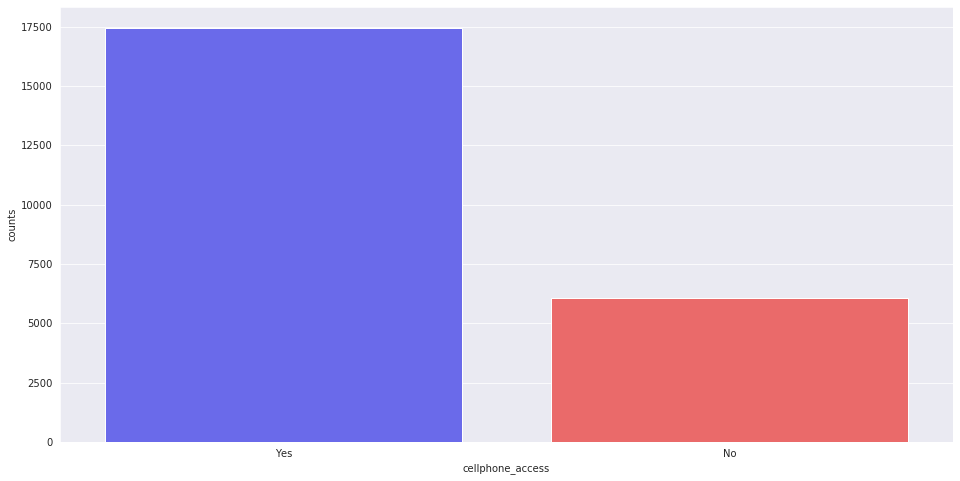

In [28]:
plt.figure(figsize=(16,8))
sb.countplot(train['cellphone_access'], palette='seismic')
plt.ylabel('counts')
plt.xlabel('cellphone_access')

### Question: How does cellphone access affect banking adaptation?

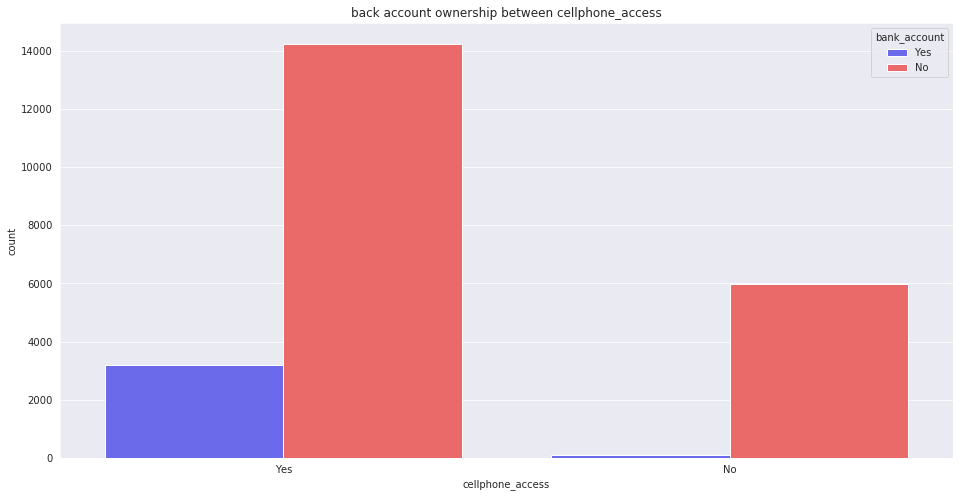

In [29]:
plt.figure(figsize=(16,8))
sb.countplot(train['cellphone_access'], hue = train['bank_account'], palette='seismic')
plt.title("back account ownership between cellphone_access")
plt.show()

### Gender_of_respondent

In [30]:
train['gender_of_respondent'].value_counts()

Female    13877
Male       9647
Name: gender_of_respondent, dtype: int64

In [31]:
test['gender_of_respondent'].value_counts()

Female    5847
Male      4239
Name: gender_of_respondent, dtype: int64

Text(0.5, 0, 'gender_of_respondent')

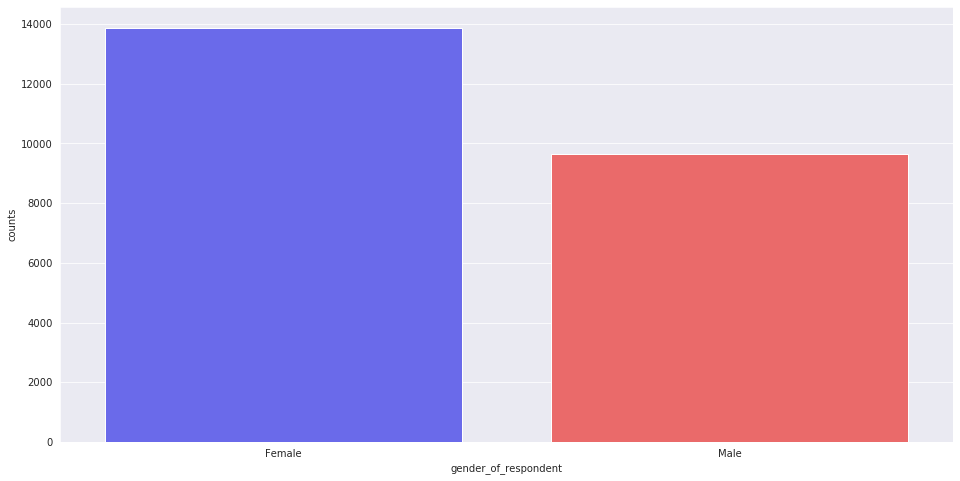

In [32]:
plt.figure(figsize=(16,8))
sb.countplot(train['gender_of_respondent'], palette='seismic')
plt.ylabel('counts')
plt.xlabel('gender_of_respondent')

### Question: Does gender affect bank adaptation?

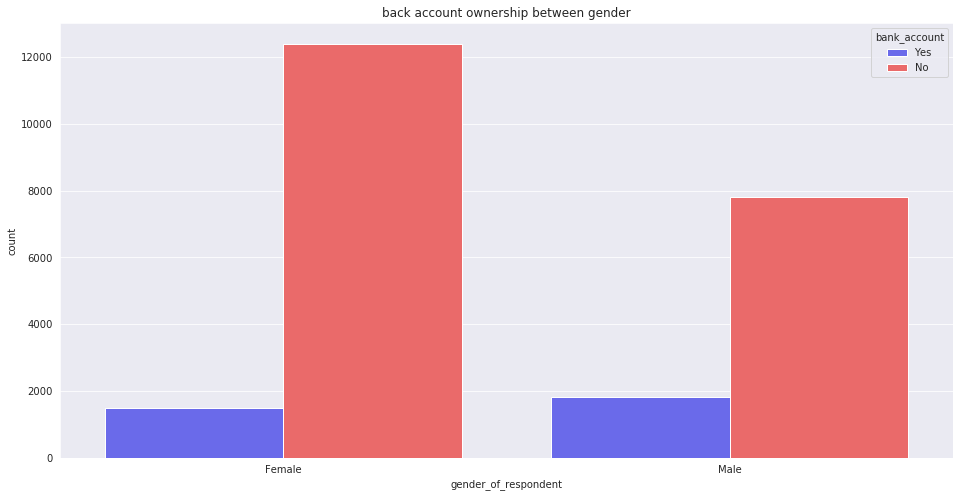

In [33]:
plt.figure(figsize=(16,8))
sb.countplot(train['gender_of_respondent'], hue = train['bank_account'], palette='seismic')
plt.title("back account ownership between gender")
plt.show()

### relationship_with_head

In [34]:
train['relationship_with_head'].value_counts()

Head of Household      12831
Spouse                  6520
Child                   2229
Parent                  1086
Other relative           668
Other non-relatives      190
Name: relationship_with_head, dtype: int64

In [35]:
test['relationship_with_head'].value_counts()

Head of Household      5487
Spouse                 2845
Child                   962
Parent                  465
Other relative          258
Other non-relatives      69
Name: relationship_with_head, dtype: int64

Text(0.5, 0, 'relationship_with_head')

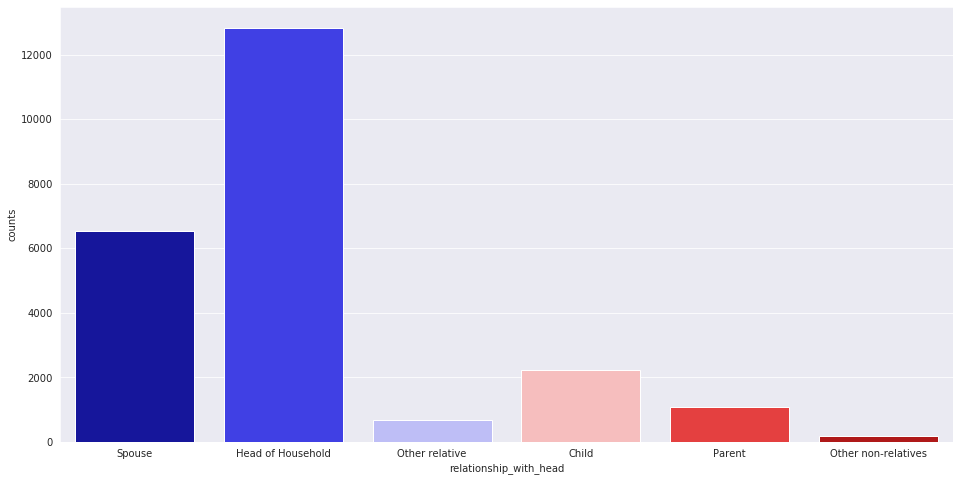

In [36]:
plt.figure(figsize=(16,8))
sb.countplot(train['relationship_with_head'], palette='seismic')
plt.ylabel('counts')
plt.xlabel('relationship_with_head')

### Question:  Whats relationship with head got to do with owning a bank account?

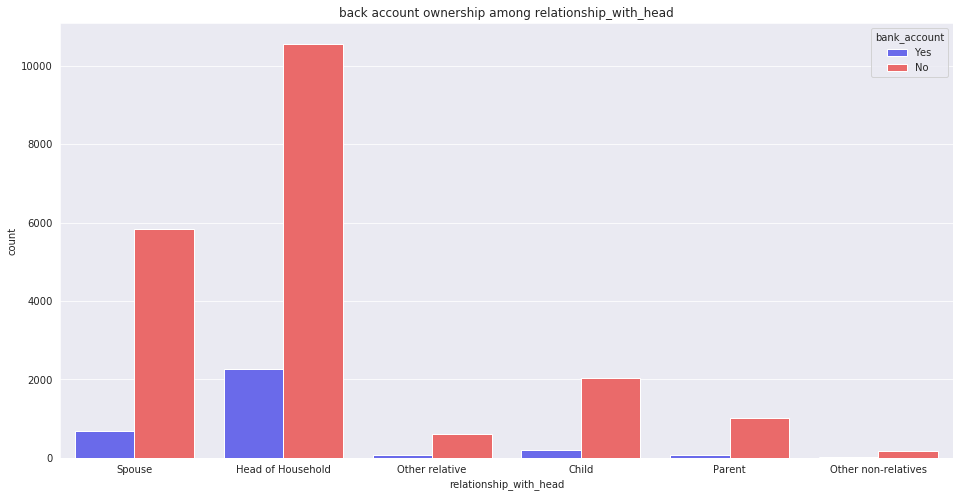

In [37]:
plt.figure(figsize=(16,8))
sb.countplot(train['relationship_with_head'], hue = train['bank_account'], palette='seismic')
plt.title("back account ownership among relationship_with_head")
plt.show()

### marital_status

In [38]:
train['marital_status'].value_counts()

Married/Living together    10749
Single/Never Married        7983
Widowed                     2708
Divorced/Seperated          2076
Dont know                      8
Name: marital_status, dtype: int64

In [39]:
test['marital_status'].value_counts()

Married/Living together    4663
Single/Never Married       3447
Widowed                    1107
Divorced/Seperated          868
Dont know                     1
Name: marital_status, dtype: int64

Text(0.5, 0, 'marital_status')

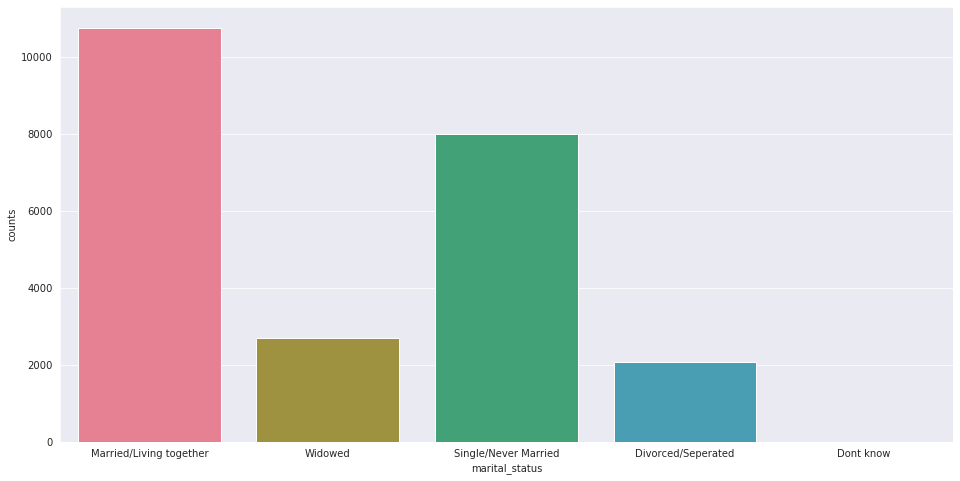

In [40]:
plt.figure(figsize=(16,8))
sb.countplot(train['marital_status'], palette='husl')
plt.ylabel('counts')
plt.xlabel('marital_status')

### QUESTION: Does the marital status of a person have a relationship with owning a bank account?


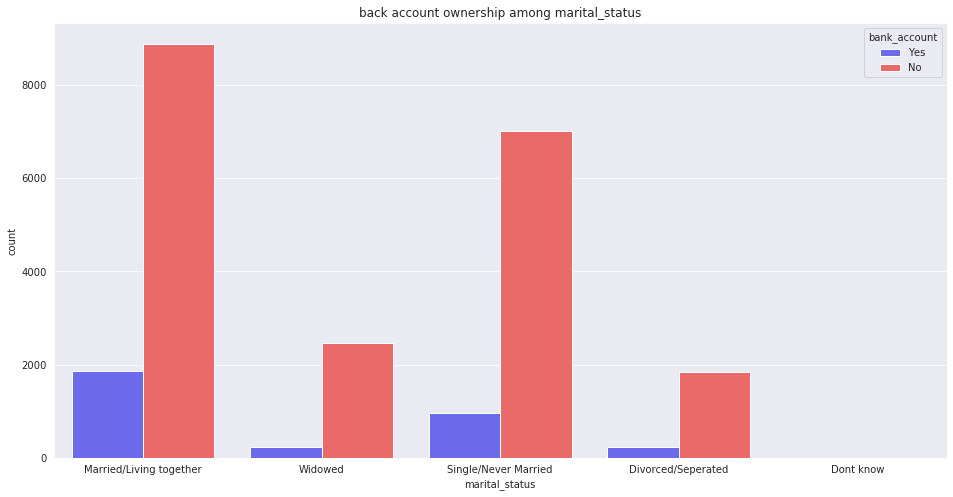

In [41]:
plt.figure(figsize=(16,8))
sb.countplot(train['marital_status'], hue = train['bank_account'], palette='seismic')
plt.title("back account ownership among marital_status")
plt.show()

### education_level


In [42]:
train['education_level'].value_counts()

Primary education                  12791
No formal education                 4515
Secondary education                 4223
Tertiary education                  1157
Vocational/Specialised training      803
Other/Dont know/RTA                   35
Name: education_level, dtype: int64

In [43]:
test['education_level'].value_counts()

Primary education                  5479
Secondary education                1902
No formal education                1836
Tertiary education                  492
Vocational/Specialised training     359
Other/Dont know/RTA                  18
Name: education_level, dtype: int64

Text(0.5, 0, 'education_level')

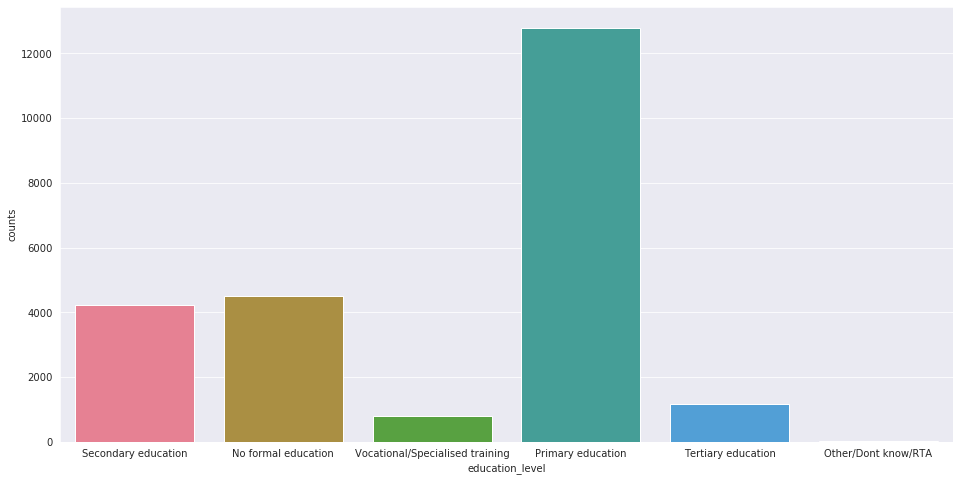

In [44]:
plt.figure(figsize=(16,8))
sb.countplot(train['education_level'], palette='husl')
plt.ylabel('counts')
plt.xlabel('education_level')

### Question:  Whats the relationship between the education level of a person and bank adaptation?


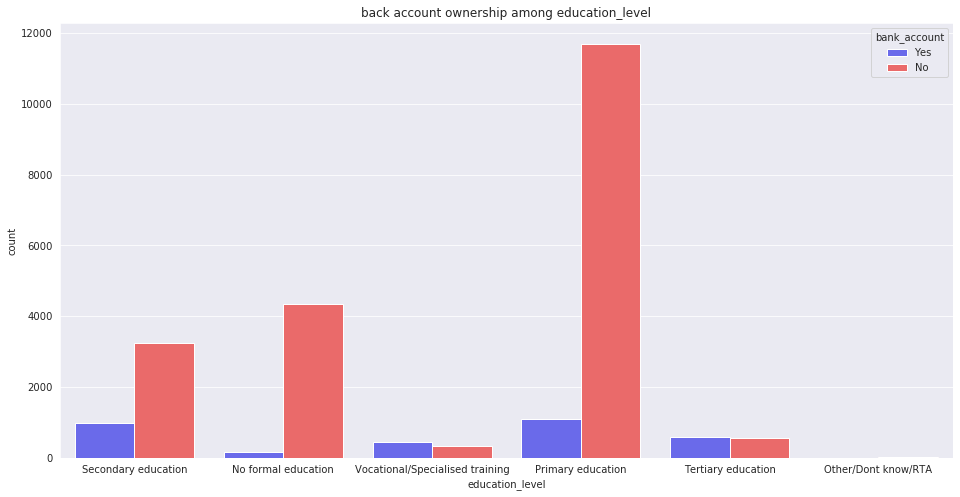

In [45]:
plt.figure(figsize=(16,8))
sb.countplot(train['education_level'], hue = train['bank_account'], palette='seismic')
plt.title("back account ownership among education_level")
plt.show()

### job_type

In [46]:
train['job_type'].value_counts()

Self employed                   6437
Informally employed             5597
Farming and Fishing             5441
Remittance Dependent            2527
Other Income                    1080
Formally employed Private       1055
No Income                        627
Formally employed Government     387
Government Dependent             247
Dont Know/Refuse to answer       126
Name: job_type, dtype: int64

In [47]:
test['job_type'].value_counts()

Self employed                   2773
Informally employed             2372
Farming and Fishing             2370
Remittance Dependent            1107
Formally employed Private        444
Other Income                     423
No Income                        276
Formally employed Government     166
Government Dependent             100
Dont Know/Refuse to answer        55
Name: job_type, dtype: int64

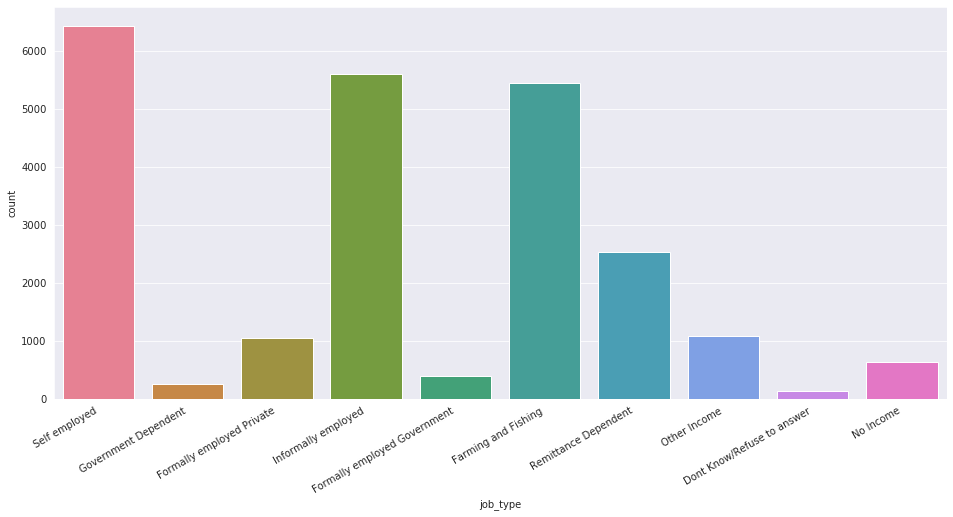

In [48]:
fig, ax = plt.subplots(figsize=(16,8))
sb.countplot(train['job_type'], palette='husl')
ax.xaxis_date()     # interpret the x-axis values as dates
fig.autofmt_xdate() # make space for and rotate the x-axis tick labels
plt.show()


### Question: Does job type affect bank adaptation?

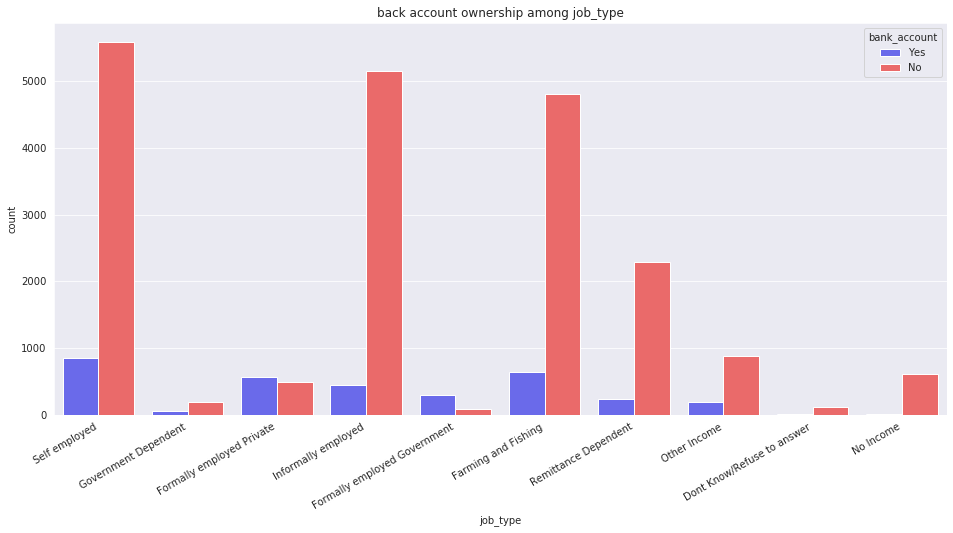

In [49]:
fig, ax = plt.subplots(figsize=(16,8))
sb.countplot(train['job_type'], hue = train['bank_account'], palette='seismic')
plt.title("back account ownership among job_type")
ax.xaxis_date()     # interpret the x-axis values as dates
fig.autofmt_xdate() # make space for and rotate the x-axis tick labels
plt.show()

## Numerical columns
* we use boxplots and distplots
* age and household size behave like categorical columns so we can visualize them with bar charts too
* As for age, we will use boxplots and dist plots

In [50]:
# check unique values in dataset
train[num_columns].apply(lambda x: len(x.unique()))

year                  3
household_size       20
age_of_respondent    85
dtype: int64

### Year

In [51]:
train['year'].value_counts()

2016    8735
2018    8169
2017    6620
Name: year, dtype: int64

In [52]:
test['year'].value_counts()

2016    3745
2018    3502
2017    2839
Name: year, dtype: int64

Text(0.5, 0, 'year')

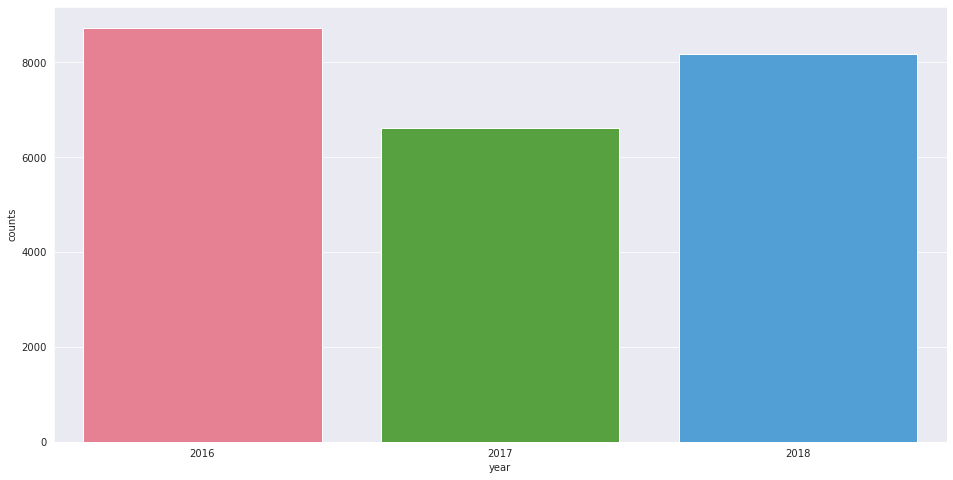

In [53]:
plt.figure(figsize=(16,8))
sb.countplot(train['year'], palette='husl')
plt.ylabel('counts')
plt.xlabel('year')

### Question: Is there any relationship between bank adaptation and year? How is the relationship?

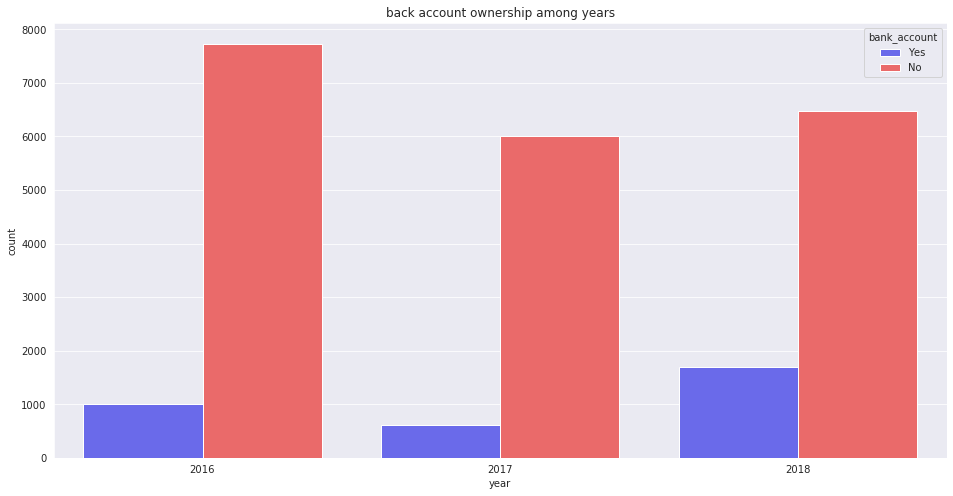

In [54]:
plt.figure(figsize=(16,8))
sb.countplot(train['year'], hue = train['bank_account'], palette='seismic')
plt.title("back account ownership among years")
plt.show()

### House_Hold size

In [55]:
train['household_size'].value_counts()

2     5229
3     3920
4     3474
1     3057
5     2853
6     2096
7     1400
8      751
9      363
10     190
11      69
12      68
13      25
15      11
14      10
16       4
21       1
18       1
17       1
20       1
Name: household_size, dtype: int64

In [56]:
test['household_size'].value_counts()

2     2272
3     1638
4     1492
1     1320
5     1282
6      877
7      580
8      321
9      147
10      86
12      28
11      25
13       6
15       5
16       3
20       2
14       1
18       1
Name: household_size, dtype: int64

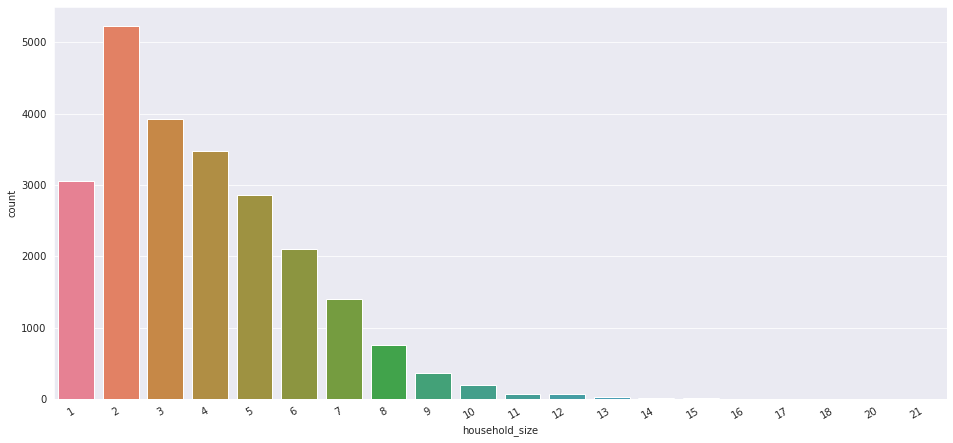

In [57]:
fig, ax = plt.subplots(figsize=(16,8))
sb.countplot(train['household_size'], palette='husl')
ax.xaxis_date()     # interpret the x-axis values as dates
fig.autofmt_xdate() # make space for and rotate the x-axis tick labels
plt.show()


### Question: What is the relationship between household size and owning a bank account?

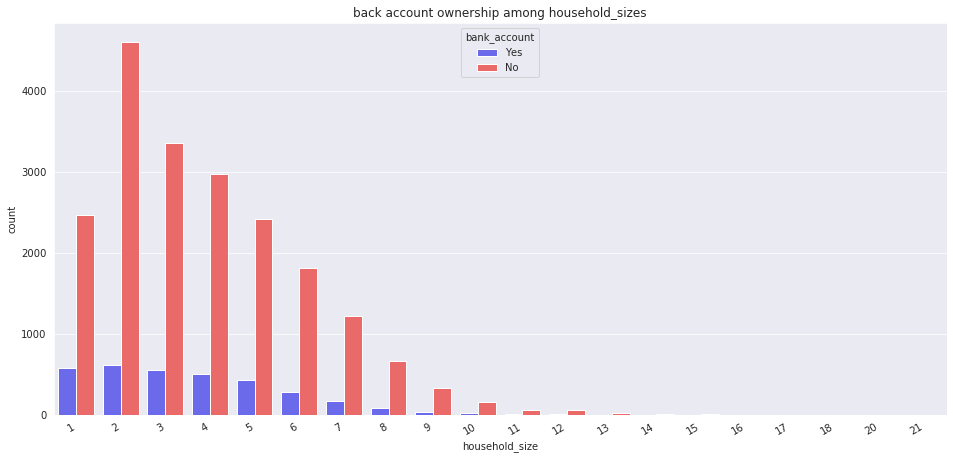

In [58]:
fig, ax = plt.subplots(figsize=(16,8))
sb.countplot(train['household_size'], hue = train['bank_account'], palette='seismic')
plt.title("back account ownership among household_sizes")
ax.xaxis_date()     # interpret the x-axis values as dates
fig.autofmt_xdate() # make space for and rotate the x-axis tick labels
plt.show()

### Age

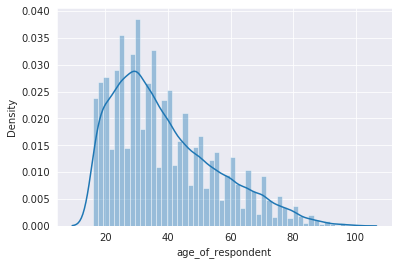

In [59]:
sb.distplot(train['age_of_respondent'])

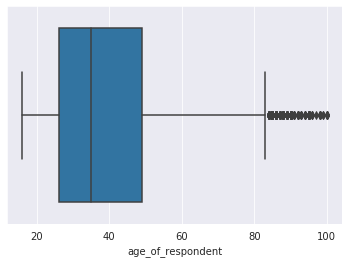

In [60]:
sb.boxplot(train['age_of_respondent'])

### Question: How does age affect bank adaptation?

Text(0.5, 0, 'bank_account')

<Figure size 1152x576 with 0 Axes>

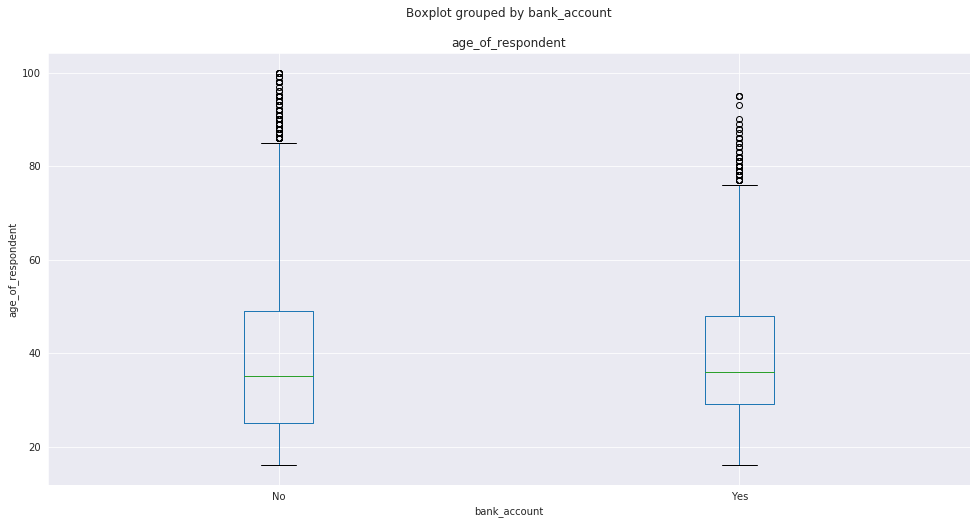

In [61]:


plt.figure(figsize=(16,8))
train.boxplot(column='age_of_respondent', by='bank_account', figsize=(16,8))
plt.ylabel('age_of_respondent')
plt.xlabel('bank_account')

## DATA PREPROCESSING
* Concat the two datasets for easier preprocessing
* Only works for competitions since you already have the two datasets but in real life scenarios you have to do them separately

In [62]:
#CONCATENATING BOTH THE TEST AND TRAIN FOR EASY DATA MANIPULATON
ntrain = train.shape[0]
ntest = test.shape[0]
data = pd.concat((train, test)).reset_index(drop=True)

### Label Encode Categorical Columns 
* We all know that computers only understand numbers so we have to convert the categorical features to numerical datatypes
* we do this through label encoding for category columns with high value counts and one hot encoding for columns with less number of value_counts e.g binary columns

In [63]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

le_columns = ['job_type', 'education_level','marital_status','relationship_with_head','country']

for col in le_columns:
    data[col] = le.fit_transform(data[col])

### One hot Encoding
* For categorical columns with less value_counts

In [64]:
data.columns

Index(['country', 'year', 'uniqueid', 'bank_account', 'location_type',
       'cellphone_access', 'household_size', 'age_of_respondent',
       'gender_of_respondent', 'relationship_with_head', 'marital_status',
       'education_level', 'job_type'],
      dtype='object')

In [65]:
data = pd.get_dummies(data, columns = ['location_type',
       'cellphone_access','year','gender_of_respondent'
])
data.head(3)

,country,uniqueid,bank_account,household_size,age_of_respondent,relationship_with_head,marital_status,education_level,job_type,location_type_Rural,location_type_Urban,cellphone_access_No,cellphone_access_Yes,year_2016,year_2017,year_2018,gender_of_respondent_Female,gender_of_respondent_Male
0,0,uniqueid_1,Yes,3,24,5,2,3,9,1,0,0,1,0,0,1,1,0
1,0,uniqueid_2,No,5,70,1,4,0,4,1,0,1,0,0,0,1,1,0
2,0,uniqueid_3,Yes,5,26,3,3,5,9,0,1,0,1,0,0,1,0,1


## Continous Features
* here we remove outliers and try to bin some

## Separate the combined dataset

In [66]:
# Separate train and test data from the combined dataframe
train_df = data[:ntrain]
test_df = data[ntrain:]

# Check the shapes of the split dataset
train_df.shape, test_df.shape

((23524, 18), (10086, 18))

### Label Encode the target

In [67]:

le_columns = ['bank_account']

for col in le_columns:
   train_df[col] = le.fit_transform(train_df[col])

## Correlation

### 1. Negative correlation with the target

In [68]:
train_df.corr()['bank_account'].sort_values()[train_df.corr()['bank_account'].sort_values() < 0]

cellphone_access_No           -0.209669
country                       -0.161362
gender_of_respondent_Female   -0.117234
year_2017                     -0.088345
location_type_Rural           -0.087288
relationship_with_head        -0.070853
job_type                      -0.064171
year_2016                     -0.057378
marital_status                -0.038739
household_size                -0.028326
Name: bank_account, dtype: float64

### 2. Positive correlation with the Target

In [69]:
train_df.corr()['bank_account'].sort_values()[train_df.corr()['bank_account'].sort_values() > 0]

age_of_respondent            0.019429
location_type_Urban          0.087288
gender_of_respondent_Male    0.117234
year_2018                    0.141673
cellphone_access_Yes         0.209669
education_level              0.323768
bank_account                 1.000000
Name: bank_account, dtype: float64

### Correlation Visually

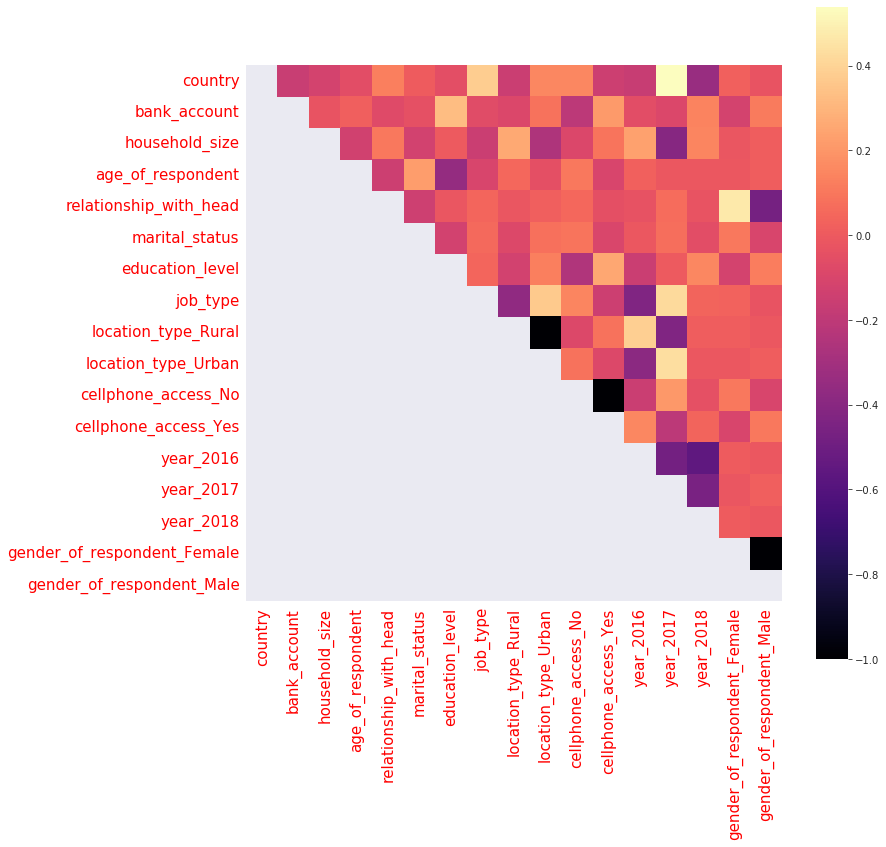

In [70]:
plt.figure(figsize = (12,12))
corr_matrix=train_df.corr()
 
matrix = np.tril(corr_matrix) # take lower correlation matrix

# Draw the heatmap with the mask
sb.heatmap(corr_matrix.T, mask=matrix, square=True, cmap = 'magma')
plt.xticks(size = 15,color = 'red')
plt.yticks(size = 15,  color = 'red');

## Feature Selection + Modelling

In [71]:
# Select main columns to be used in training
main_cols = train_df.columns.difference(['uniqueid','bank_account'])
X = train_df[main_cols]
y = train_df.bank_account
test = test_df[main_cols]
model = catt.CatBoostClassifier(random_state = 42,)

import random
random.seed(123)

train_features, valid_features, train_y, valid_y = train_test_split(X, y, test_size = 0.18, stratify = y,random_state = 47)
model.fit(train_features, train_y,eval_set = [(train_features, train_y),(valid_features,valid_y)], early_stopping_rounds = 500, 
          verbose = 200)

Learning rate set to 0.065823
0:	learn: 0.6250104	test: 0.6250787	test1: 0.6255180	best: 0.6255180 (0)	total: 52ms	remaining: 51.9s
200:	learn: 0.2586019	test: 0.2586495	test1: 0.2687026	best: 0.2682818 (174)	total: 1.26s	remaining: 4.99s
400:	learn: 0.2413918	test: 0.2414369	test1: 0.2705098	best: 0.2682818 (174)	total: 2.59s	remaining: 3.88s
600:	learn: 0.2292406	test: 0.2292845	test1: 0.2733961	best: 0.2682818 (174)	total: 3.85s	remaining: 2.55s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.2682817776
bestIteration = 174

Shrink model to first 175 iterations.


## Visualize the Feature Importance

In [72]:
pd.options.display.max_rows = 2200
#define a function to create variable importance dataframe
def get_catt_varimp(model, train_columns, max_vars=350):
    
    # Scikit-learn API LGBMClassifier or LGBMRegressor was fitted, 
    # so using feature_importances_ property
    feature_importances_perc = (model.feature_importances_ / sum(model.feature_importances_)) * 100
    cv_varimp_df = pd.DataFrame([train_columns, feature_importances_perc]).T

    cv_varimp_df.columns = ['feature_name', 'varimp (%)']

    cv_varimp_df.sort_values(by='varimp (%)', ascending=False, inplace=True)

    cv_varimp_df = cv_varimp_df.iloc[0:max_vars]   

    return cv_varimp_df
#
get_catt_varimp(model, X.columns)

,feature_name,varimp (%)
4,education_level,15.754191
8,job_type,11.938398
0,age_of_respondent,11.871354
2,cellphone_access_Yes,11.276551
3,country,10.256105
1,cellphone_access_No,10.164923
12,relationship_with_head,4.935777
15,year_2018,4.277831
10,location_type_Urban,3.938246
11,marital_status,3.421756


### MODELLING

In [80]:
fold_pred=[]
oof_pred = []

params =     params = {
        'iterations':10000,
        'random_state':42,
        'bootstrap_type':'Bernoulli',
        'max_depth': 7,
        'learning_rate': 0.008436034013684798,
        'l2_leaf_reg': 0.8908564261285311,

        
   
        
         }
 




fold= StratifiedKFold(n_splits=10)#15#5#10
i=1
for train_index, test_index in fold.split(X,y):     
  
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    


    model = catt.CatBoostClassifier(**params)

    model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=250, verbose = False)#erly100

    preds= model.predict_proba(X_test)
    print("err: ",(log_loss(y_test,preds))) 
#     print("roc: ",(roc_auc_score(y_test,preds[:,1]))) 
    oof_pred.append(log_loss(y_test,preds))
    p2 = model.predict_proba(test_df[X.columns])
    fold_pred.append(p2)
    

print(np.mean(oof_pred))

err:  0.300363864023675
err:  0.2895277727956614
err:  0.4494208579323263
err:  0.24643071372607472
0.32143580211943434


#### 0.30578246314217933

Text(0.5, 1.0, 'CatBoostClassifier features importance (top 50):')

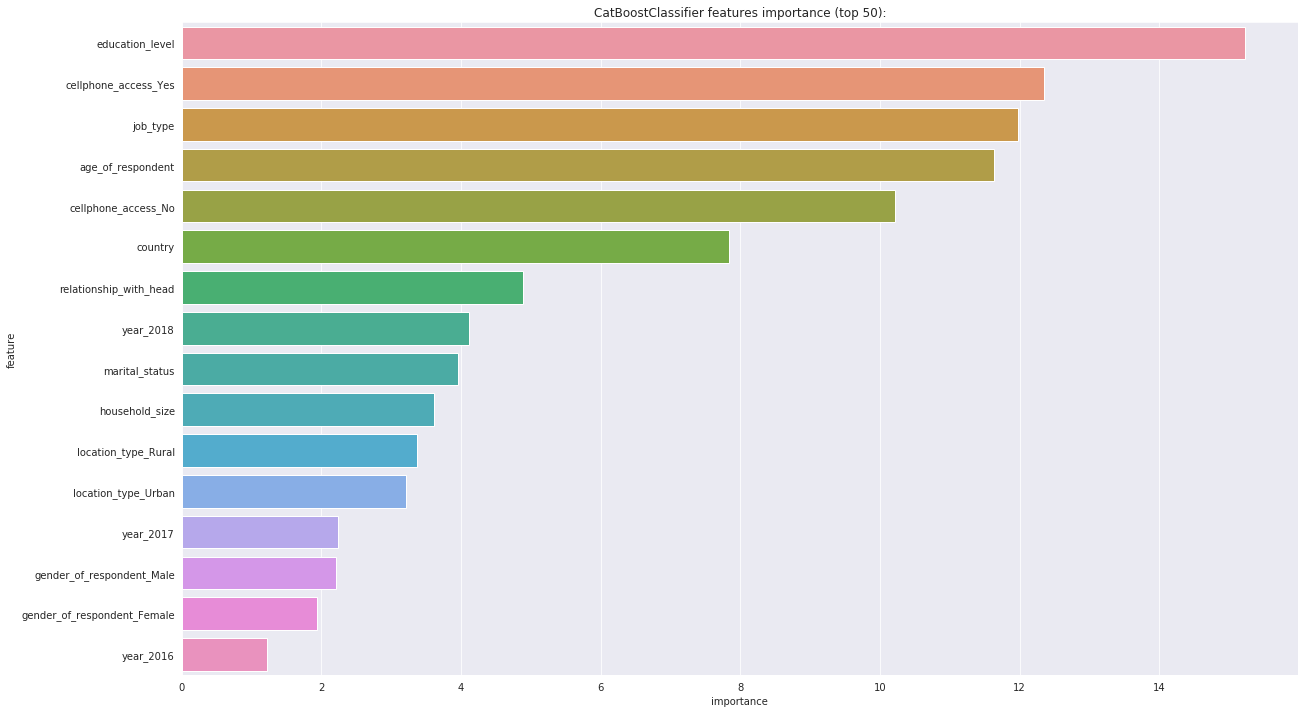

In [81]:
feature_importance_df = pd.DataFrame(model.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = X.columns

plt.figure(figsize=(20, 12));
sb.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by = ['importance'], ascending = False).head(60))
plt.title('CatBoostClassifier features importance (top 50):')

### Submission

In [82]:
# Create submission DataFrame
ftest['bank_account'] = 0
submission = pd.DataFrame({"uniqueid": ftest["uniqueid"] + " x " + ftest["country"],
                           "bank_account": ftest.bank_account})
preds = np.mean(fold_pred,axis=0)
submission['bank_account'] = preds[:,1]

In [83]:
submission['bank_account'] = submission['bank_account'] >= 0.5
submission['bank_account'] = le.fit_transform(submission['bank_account'])
submission.head()

,uniqueid,bank_account
0,uniqueid_6056 x Kenya,1
1,uniqueid_6060 x Kenya,1
2,uniqueid_6065 x Kenya,0
3,uniqueid_6072 x Kenya,0
4,uniqueid_6073 x Kenya,0


In [84]:
submission.to_csv(path + 'gcv_submission.csv', index=False)

In [85]:
submission.bank_account.value_counts()

0    9474
1     612
Name: bank_account, dtype: int64